# <font style="font-size: 26px;" color='red'> Brain MRI Detector & Segmentation using Attention U-Net</font>
## <font style="font-size: 18px;" color='green'>Introduction</font>
<span style="font-size: 13px;">
The **Attention U-Net** is an advanced variation of the traditional U-Net architecture, designed specifically to improve the performance of image segmentation tasks. It is widely used in medical imaging, particularly for tasks such as tumor segmentation in MRI scans. The model incorporates an attention mechanism that helps it focus on the most relevant regions of the image, which is crucial when working with complex and noisy data like medical images.
</span>

## <font style="font-size: 18px;" color='green'>Definition of Attention U-Net</font>
<span style="font-size: 13px;">
The **Attention U-Net** integrates an attention mechanism into the original U-Net model. The attention mechanism used in this architecture is based on the **Attention Gate (AG)**, which allows the model to focus on regions of interest while ignoring irrelevant or noisy parts of the image. This results in more accurate segmentation, especially when dealing with small, complex, and overlapping structures in medical images, such as tumors or organs.
</span>

## <font style="font-size: 18px;" color='green'>Why is Attention Necessary in U-Net?</font>
<span style="font-size: 13px;">
In traditional U-Net, the model is trained to learn features from the entire image, but this can lead to the model focusing on irrelevant or non-target areas, reducing performance, especially in medical imaging tasks where the target structures can be very small or irregular.

The addition of attention gates helps to:

1. **Highlight Relevant Features**: Attention mechanisms guide the model to focus on the important regions of the image, such as the tumor in MRI scans, which improves segmentation accuracy.
   
2. **Suppress Irrelevant Regions**: The attention mechanism filters out irrelevant parts of the image, which reduces the risk of overfitting to noisy regions.

3. **Improve Model Generalization**: By focusing on the most important parts of the image, the model is able to generalize better to new, unseen images, making it more robust in real-world applications.

4. **Reduce Training Time**: Attention allows the model to focus on the most relevant features, helping it converge faster during training and improve efficiency.
</span>

## <font style="font-size: 18px;" color='green'>Architecture of Attention U-Net</font>
<span style="font-size: 13px;">
The **Attention U-Net** architecture follows a similar structure to the original U-Net, which consists of an encoder-decoder architecture with skip connections. The key difference is the introduction of **Attention Gates (AGs)** within the skip connections. These gates use learned attention maps to focus on the most important features while suppressing irrelevant ones.

- **Encoder**: The encoder extracts feature maps from the input image through several convolutional layers, progressively reducing the spatial dimensions.
  
- **Decoder**: The decoder reconstructs the segmentation mask by upsampling the feature maps, using skip connections from the encoder to preserve fine-grained details.

- **Attention Gates**: The attention gates are placed between the encoder and decoder to ensure that only relevant features are passed along the skip connections, reducing the impact of irrelevant regions.
</span>
![Segmentation de Tumeur](../Images/attention_unet.png)


## <font style="font-size: 18px;" color='green'> **Model Training and Evaluation** </font>
<span style="font-size: 13px;">
The model was trained and evaluated using the **MRI Brain Tumor Dataset**. The following metrics were used to evaluate the model's performance:

- **Dice Coefficient**: Measures the overlap between the predicted and true segmentation masks.
- **IoU (Intersection over Union)**: Measures the intersection between the predicted and true masks, normalized by their union.
- **Loss**: The loss function used for training, which is minimized during the optimization process.
- **Precision and Recall**: Measures the accuracy of the model’s positive predictions (precision) and its ability to detect true positives (recall).
</span>

## <font style="font-size: 18px;" color="green">Test Results</font>
<span style="font-size: 13px;">
After evaluating the model on the test set, the following metrics were obtained:

- **Test Loss**: 0.1050
- **Test Dice Coefficient**: 0.8949
- **Test IoU**: 0.8108
- **Test Precision**: 0.8939
- **Test Recall**: 0.9046


The test results show that the model generalizes well to unseen data and maintains high performance in terms of both precision and recall.
</span>

## <font style="font-size: 18px;" color="green">Implementation of the Attention U-Net for Brain Tumor Segmentation</font>

<span style="font-size: 13px;">
In this section, we implement the **Attention U-Net** model for **brain tumor segmentation** using **TensorFlow** and **Keras**. The model is based on the standard U-Net architecture, but with the addition of **Attention Gates** to help the network focus on relevant regions of the image. This attention mechanism improves segmentation accuracy, especially in medical images where the target structures, such as tumors, may be small or irregular in shape.

The steps involved in this implementation include:

1. **Data Preprocessing**: Loading and preprocessing MRI images and their corresponding ground truth segmentation masks.
2. **Model Architecture**: Defining the Attention U-Net architecture, which includes:
   - Encoder: Extracting features from the input image.
   - Decoder: Reconstructing the segmentation mask from the extracted features.
   - Attention Gates: Focusing on relevant parts of the image by suppressing irrelevant regions in the skip connections.
3. **Model Training**: Training the model on the preprocessed data using the **Dice coefficient**, **IoU**, and other metrics as the evaluation criteria.
4. **Evaluation**: Evaluating the trained model on a test set to measure its performance in terms of **test loss**, **Dice coefficient**, **IoU**, **precision**, and **recall**.
</span>

<span style="font-size: 13px;"> This implementation leverages TensorFlow and Keras for efficient model building, training, and evaluation. The final model can effectively segment brain tumors in MRI images with high accuracy.
</span>
---


In [2]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
 99%|████████████████████████████████████████▌| 706M/714M [00:02<00:00, 333MB/s]
100%|█████████████████████████████████████████| 714M/714M [00:02<00:00, 335MB/s]


In [3]:
import zipfile

with zipfile.ZipFile('lgg-mri-segmentation.zip', 'r') as zip_ref:
    files_to_extract = [f for f in zip_ref.namelist() if f.startswith("kaggle_3m/")]
    
    zip_ref.extractall('/kaggle/working/lgg_mri_segmentation', members=files_to_extract)

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

plt.style.use("ggplot")
%matplotlib inline
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import backend as K

In [ ]:

def check_tumor_in_mask(mask_path):
    try:
        img = Image.open(mask_path)
        img = np.array(img)

        if np.max(img) > 0:
            return 1 
        else:
            return 0 
    except Exception as e:
        print(f"Erreur de lecture du masque {mask_path}: {e}")
        return -1 

DataPath = "/kaggle/working/lgg_mri_segmentation/kaggle_3m/"

dirs = []
images = []
masks = []
diagnoses = []

for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if 'mask' in filename:  
           
            mask_path = os.path.join(dirname, filename)
            dirs.append(dirname.replace(DataPath, ''))
            masks.append(filename)
            
            images.append(filename.replace('_mask', '')) 
            diagnosis = check_tumor_in_mask(mask_path)
            diagnoses.append(diagnosis)

patient_mri_df = pd.DataFrame({'patient_id': dirs, 'images': images, 'masks': masks, 'diagnosis': diagnoses})

patient_mri_df.head()

patient_id                        images  \
0  TCGA_HT_7602_19951103  TCGA_HT_7602_19951103_16.tif   
1  TCGA_HT_7602_19951103  TCGA_HT_7602_19951103_11.tif   
2  TCGA_HT_7602_19951103  TCGA_HT_7602_19951103_20.tif   
3  TCGA_HT_7602_19951103  TCGA_HT_7602_19951103_19.tif   
4  TCGA_HT_7602_19951103  TCGA_HT_7602_19951103_10.tif   

                               masks  diagnosis  
0  TCGA_HT_7602_19951103_16_mask.tif          0  
1  TCGA_HT_7602_19951103_11_mask.tif          1  
2  TCGA_HT_7602_19951103_20_mask.tif          0  
3  TCGA_HT_7602_19951103_19_mask.tif          0  
4  TCGA_HT_7602_19951103_10_mask.tif          1

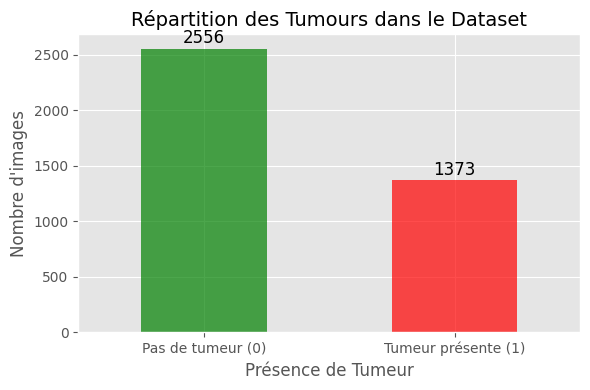

In [6]:
import matplotlib.pyplot as plt
diagnosis_counts = patient_mri_df['diagnosis'].value_counts()

plt.figure(figsize=(6, 4))
diagnosis_counts.plot(kind='bar', color=['green', 'red'], alpha=0.7)
plt.title('Répartition des Tumours dans le Dataset', fontsize=14)
plt.xlabel('Présence de Tumeur', fontsize=12)
plt.ylabel('Nombre d\'images', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Pas de tumeur (0)', 'Tumeur présente (1)'], rotation=0)
for i, count in enumerate(diagnosis_counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()

In [7]:
pip install imageio

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


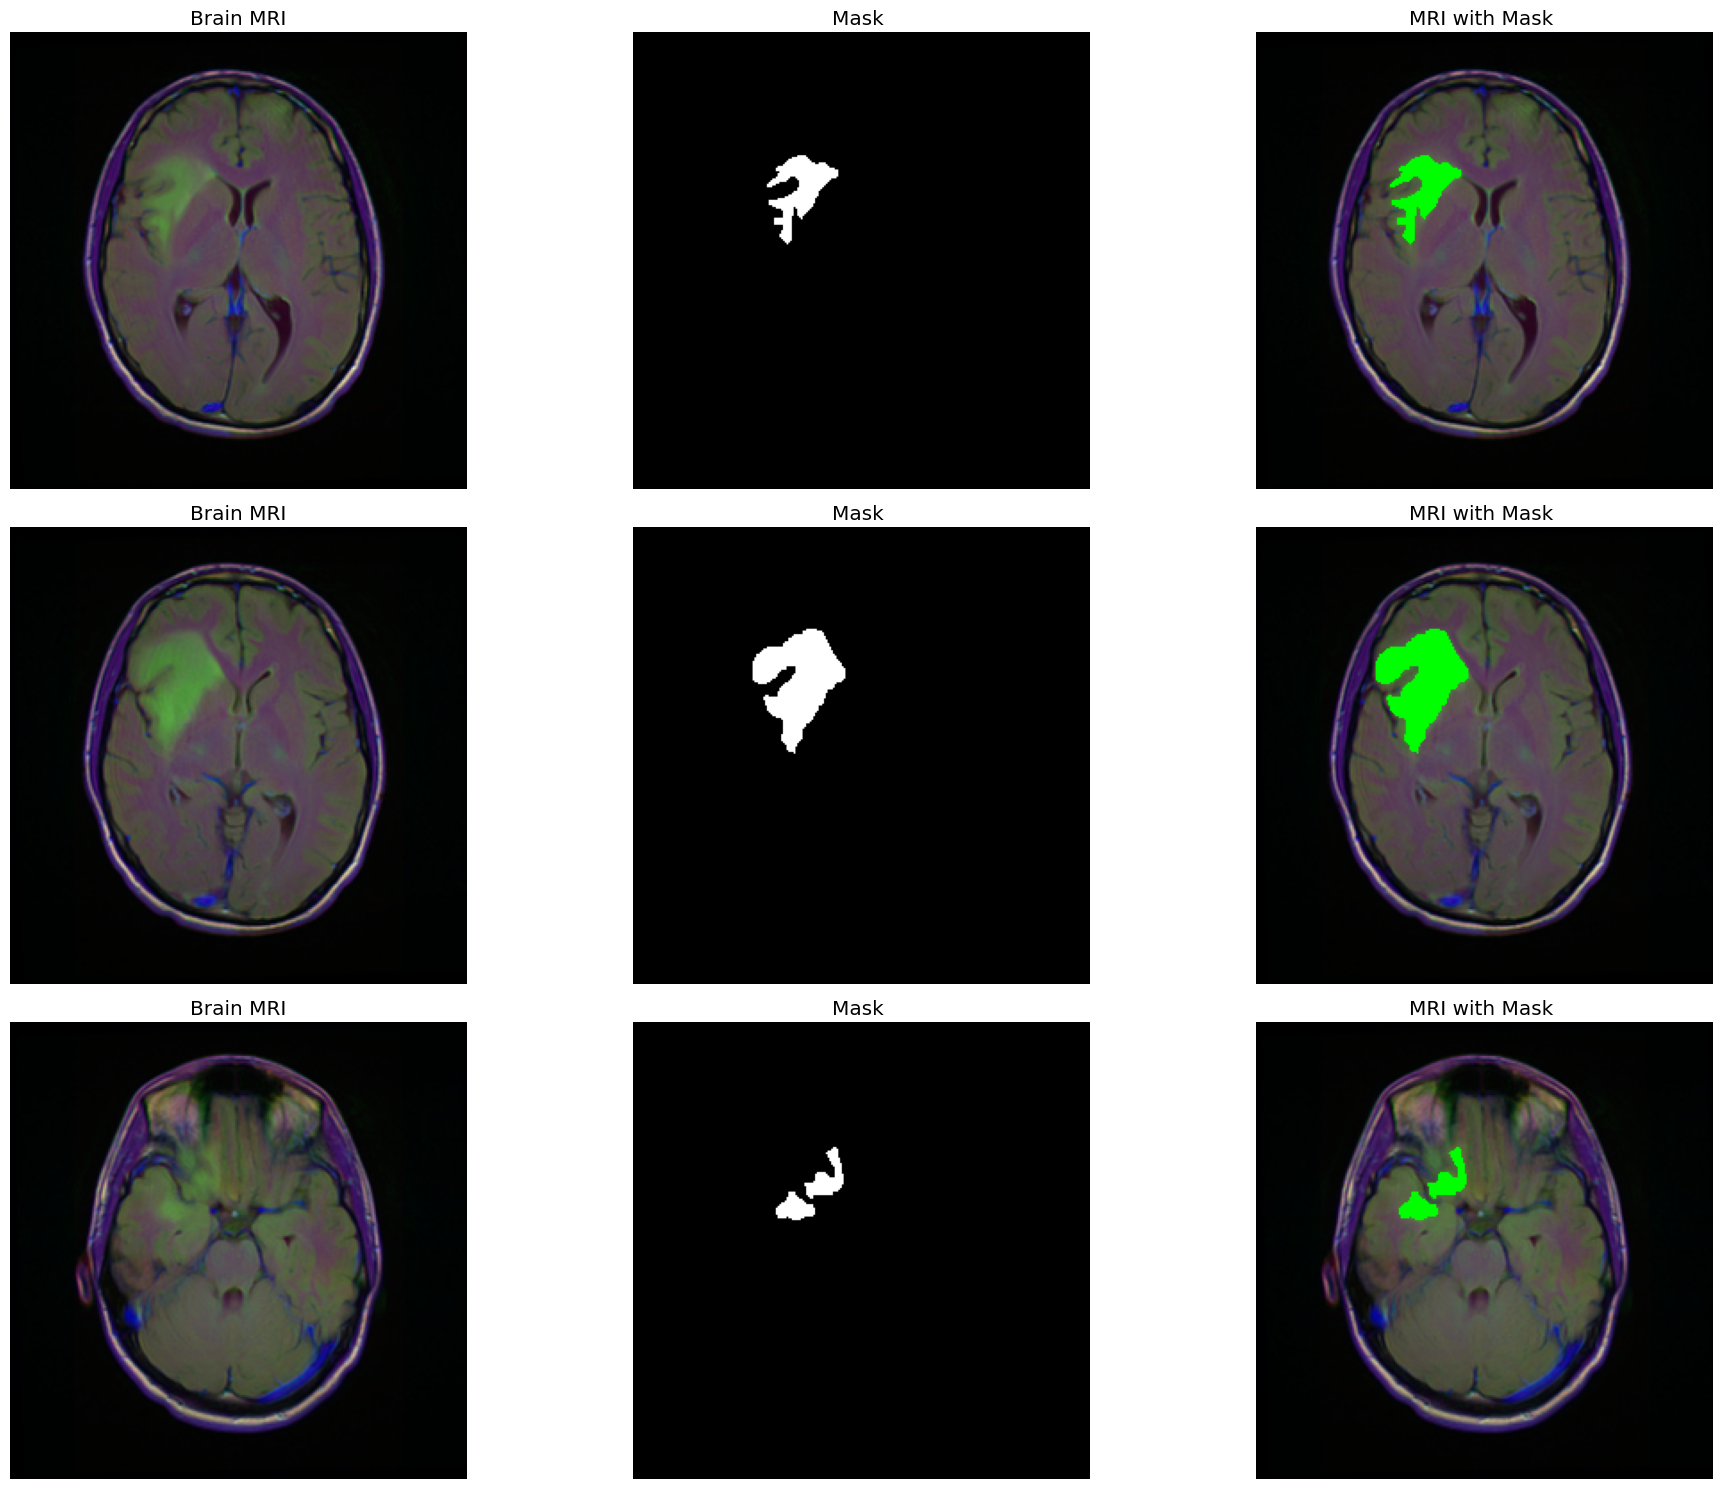

In [8]:
import os
from skimage.io import imread
import matplotlib.pyplot as plt

count = 0
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
axs = axs.flatten()

for i, row in patient_mri_df.iterrows():
    if row['diagnosis'] == 1:
        img_path = os.path.join(DataPath, row['patient_id'], row['images'])
        mask_path = os.path.join(DataPath, row['patient_id'], row['masks'])

        img = imread(img_path)  
        mask = imread(mask_path)  

        axs[count].imshow(img)
        axs[count].set_title("Brain MRI")
        axs[count].axis('off')

        axs[count + 1].imshow(mask, cmap='gray')
        axs[count + 1].set_title(f"Mask ")
        axs[count + 1].axis('off')

        img_with_mask = img.copy()
        img_with_mask[mask == 255] = (0, 255, 0)
        axs[count + 2].imshow(img_with_mask)
        axs[count + 2].set_title(f"MRI with Mask ")
        axs[count + 2].axis('off')

        count += 3

    if count >= 9:
        break

fig.tight_layout()
plt.show()

In [33]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(patient_mri_df, test_size=0.25, random_state=25)

train, val = train_test_split(train, test_size=0.1, random_state=25)

print(f"Taille de l'ensemble d'entraînement: {len(train)}")
print(f"Taille de l'ensemble de validation: {len(val)}")
print(f"Taille de l'ensemble de test: {len(test)}")

print(test.head())

Taille de l'ensemble d'entraînement: 2651
Taille de l'ensemble de validation: 295
Taille de l'ensemble de test: 983
                 patient_id                        images  \
1006  TCGA_CS_6669_20020102  TCGA_CS_6669_20020102_16.tif   
1217  TCGA_CS_5397_20010315   TCGA_CS_5397_20010315_1.tif   
3267  TCGA_HT_8563_19981209   TCGA_HT_8563_19981209_3.tif   
2033  TCGA_EZ_7264_20010816  TCGA_EZ_7264_20010816_13.tif   
3419  TCGA_DU_7010_19860307  TCGA_DU_7010_19860307_55.tif   

                                  masks  diagnosis  
1006  TCGA_CS_6669_20020102_16_mask.tif          1  
1217   TCGA_CS_5397_20010315_1_mask.tif          0  
3267   TCGA_HT_8563_19981209_3_mask.tif          0  
2033  TCGA_EZ_7264_20010816_13_mask.tif          0  
3419  TCGA_DU_7010_19860307_55_mask.tif          0  


In [10]:
data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from skimage import io
import pandas as pd

def adjust_data(img, mask):
    img = img / 255  
    mask = mask / 255  
    
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return img, mask

def data_generator(data_frame, batch_size, aug_dict,
                   image_color_mode="rgb", mask_color_mode="grayscale",
                   image_save_prefix="image", mask_save_prefix="mask",
                   save_to_dir=None, target_size=(256, 256), seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="images",  
        class_mode=None,  
        color_mode=image_color_mode,
        target_size=target_size,  
        batch_size=batch_size,
        save_to_dir=save_to_dir, 
        save_prefix=image_save_prefix,
        seed=seed
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="masks",  
        class_mode=None,  
        color_mode=mask_color_mode,
        target_size=target_size,  
        batch_size=batch_size,
        save_to_dir=save_to_dir,  
        save_prefix=mask_save_prefix,
        seed=seed
    )

    train_generator = zip(image_generator, mask_generator)

    for (img, mask) in train_generator:
        img, mask = adjust_data(img, mask)  
        yield img, mask

In [12]:
train['images'] = train.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['images']), axis=1)
train['masks'] = train.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['masks']), axis=1)


train_generator = data_generator(
    data_frame=train,  
    batch_size=16,         
    aug_dict=data_augmentation,  
    target_size=(256, 256)  
)
train.head()

patient_id  \
2754  TCGA_CS_6186_20000601   
1556  TCGA_CS_4944_20010208   
1620  TCGA_DU_6401_19831001   
1067  TCGA_FG_6689_20020326   
3616  TCGA_HT_7475_19970918   

                                                 images  \
2754  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
1556  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
1620  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
1067  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
3616  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   

                                                  masks  diagnosis  
2754  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
1556  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          1  
1620  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
1067  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
3616  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          1

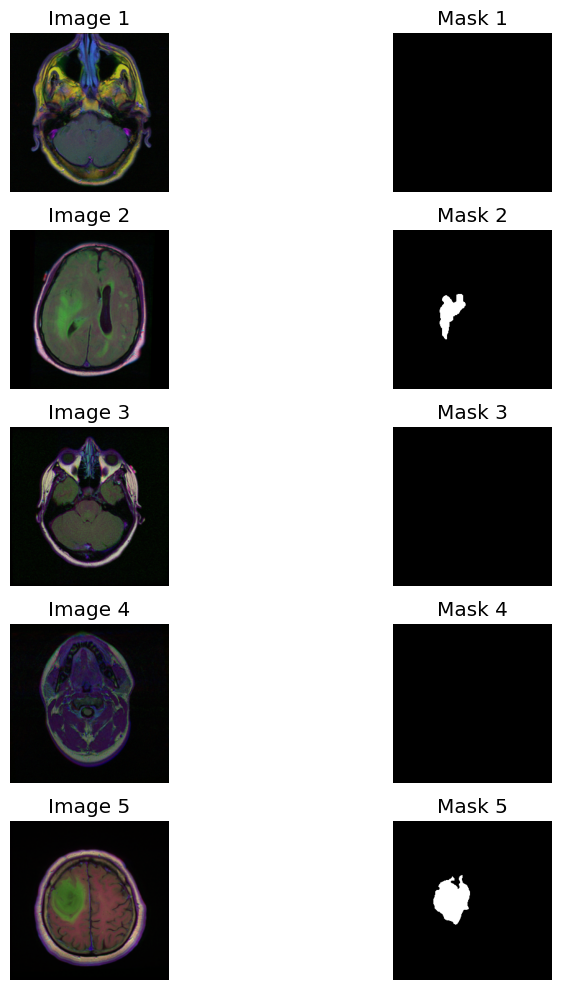

In [13]:
import matplotlib.pyplot as plt
import cv2

num_images_to_show = 5  
fig, axes = plt.subplots(num_images_to_show, 2, figsize=(10, 10))

for i in range(num_images_to_show):
    image_path = train.iloc[i]['images'] 
    mask_path = train.iloc[i]['masks']   
    
    image = cv2.imread(image_path)  
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    image = cv2.resize(image, (256, 256))
    mask = cv2.resize(mask, (256, 256))

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    axes[i, 0].imshow(image_rgb)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Image {i + 1}")
    
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Mask {i + 1}")

plt.tight_layout()
plt.show()

In [14]:
val['images'] = val.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['images']), axis=1)
val['masks'] = val.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['masks']), axis=1)

val_generator = data_generator(
    data_frame=val,  
    batch_size=16,      
    aug_dict={},         
    target_size=(256, 256)  
)

In [15]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model

def conv_block(x, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)

    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)

    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)

    return out * s

def decoder_block(x, s, num_filters):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

def attention_unet(input_shape):
    """ Inputs """
    inputs = L.Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    b1 = conv_block(p3, 512)

    """ Decoder """
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    """ Outputs """
    outputs = L.Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    """ Model """
    model = Model(inputs, outputs, name="Attention-UNET")
    return model

if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = attention_unet(input_shape)
    model.summary()

Model: "Attention-UNET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 8,143,169 (31.06 MB)

 Trainable params: 8,135,745 (31.04 MB)

 Non-trainable params: 7,424 (29.00 KB)

In [16]:
smooth = 1

def iou_score(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (union - intersection + smooth)
    return iou

def dice_coefficient(y_true, y_pred):
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_true_flat * y_pred_flat)
    dice = (2 * intersection + smooth) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + smooth)
    return dice

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

lr_reduction = ReduceLROnPlateau(monitor='val_dice_coefficient', patience=8, verbose=1, factor=0.4, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_dice_coefficient', min_delta=0.00001, patience=6, mode='max', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('unet_model.keras', monitor='val_dice_coefficient', verbose=1, save_best_only=True, mode='max')

In [25]:
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.optimizers import Adam

learning_rate = 0.0001
EPOCH = 100


model.compile(
    optimizer=Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.9, epsilon=1e-07, amsgrad=False),
    loss=dice_coefficient_loss,
    metrics=[dice_coefficient, iou_score, Recall(), Precision()]
)

steps_per_epoch = int(len(train) / 16)
validation_steps = int(len(val) / 16)
print(steps_per_epoch)
print(validation_steps)
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCH,
    validation_data=val_generator,
    validation_steps=validation_steps,
   # callbacks=[lr_reduction,early_stop, model_checkpoint]
)


165
18
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 115s 582ms/step - dice_coefficient: 0.8318 - iou_score: 0.7216 - loss: 0.1685 - precision_1: 0.8750 - recall_1: 0.8308 - val_dice_coefficient: 0.8502 - val_iou_score: 0.7434 - val_loss: 0.1502 - val_precision_1: 0.9129 - val_recall_1: 0.8138
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 87s 526ms/step - dice_coefficient: 0.8349 - iou_score: 0.7262 - loss: 0.1649 - precision_1: 0.8756 - recall_1: 0.8367 - val_dice_coefficient: 0.8449 - val_iou_score: 0.7413 - val_loss: 0.1541 - val_precision_1: 0.8862 - val_recall_1: 0.8552
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 87s 526ms/step - dice_coefficient: 0.8458 - iou_score: 0.7412 - loss: 0.1542 - precision_1: 0.8922 - recall_1: 0.8368 - val_dice_coefficient: 0.8497 - val_iou_score: 0.7450 - val_loss: 0.1527 - val_precision_1: 0.9266 - val_recall_1: 0.7834
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 87s 525ms/step - dice_coefficient: 0.8289 - iou_score: 0.7197 - loss: 0.1708 - precision_1: 0.8768 - reca

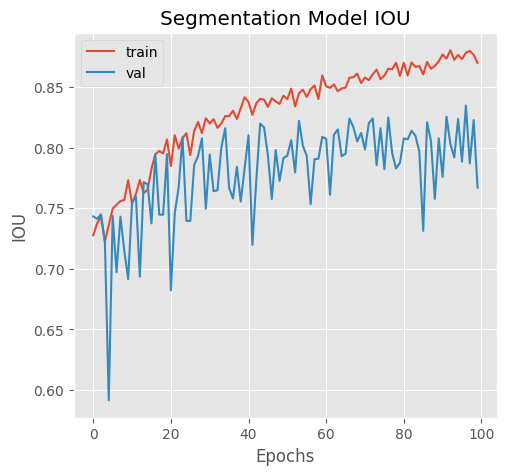

In [26]:

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['iou_score']);
plt.plot(history.history['val_iou_score']);
plt.title("Segmentation Model IOU");
plt.ylabel("IOU");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

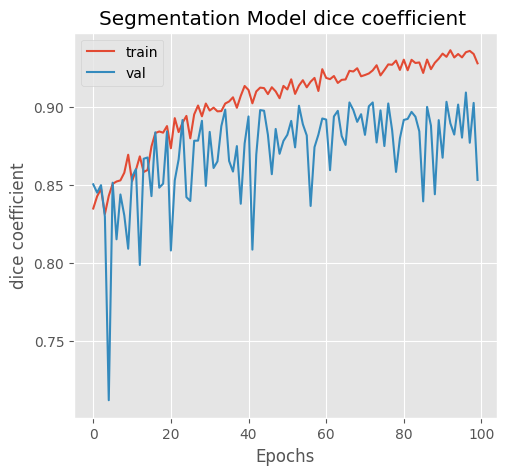

In [27]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['dice_coefficient']);
plt.plot(history.history['val_dice_coefficient']);
plt.title("Segmentation Model dice coefficient ");
plt.ylabel("dice coefficient");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

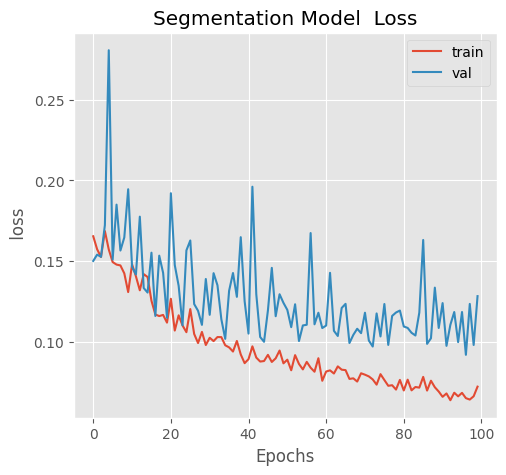

In [28]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title("Segmentation Model  Loss");
plt.ylabel(" loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [34]:
DataPath = "/kaggle/working/lgg_mri_segmentation/kaggle_3m/"
test['images'] = test.apply(lambda row: DataPath + row['patient_id'] + "/" + row['images'], axis=1)
test['masks'] = test.apply(lambda row: DataPath + row['patient_id'] + "/" + row['masks'], axis=1)

print(test.head())

                 patient_id  \
1006  TCGA_CS_6669_20020102   
1217  TCGA_CS_5397_20010315   
3267  TCGA_HT_8563_19981209   
2033  TCGA_EZ_7264_20010816   
3419  TCGA_DU_7010_19860307   

                                                 images  \
1006  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
1217  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
3267  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
2033  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
3419  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   

                                                  masks  diagnosis  
1006  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          1  
1217  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
3267  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
2033  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
3419  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  


---
## <font color='green'> **Model Training and Evaluation** </font>

The model was trained and evaluated using the **MRI Brain Tumor Dataset**. The following metrics were used to evaluate the model's performance:

- **Dice Coefficient**: Measures the overlap between the predicted and true segmentation masks.
- **IoU (Intersection over Union)**: Measures the intersection between the predicted and true masks, normalized by their union.
- **Loss**: The loss function used for training, which is minimized during the optimization process.
- **Precision and Recall**: Measures the accuracy of the model’s positive predictions (precision) and its ability to detect true positives (recall).

---

In [35]:
def combined_generator(image_generator, mask_generator):
    while True:
        image_batch, mask_batch = next(image_generator), next(mask_generator)
        yield image_batch, mask_batch

image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

test_image_generator = image_datagen.flow_from_dataframe(
    dataframe=test,  
    x_col="images",   
    class_mode=None,  
    color_mode="rgb", 
    target_size=(256, 256),  
    batch_size=32,
    seed=42,
    validate_filenames=False  
)

test_mask_generator = mask_datagen.flow_from_dataframe(
    dataframe=test,  
    x_col="masks",   
    class_mode=None,  
    color_mode="grayscale",  
    target_size=(256, 256), 
    batch_size=32,
    seed=42,
    validate_filenames=False  
)

test_generator = combined_generator(test_image_generator, test_mask_generator)

steps_per_epoch_test = len(test) // 32  

test_loss, test_dice_coef, test_iou, test_recall, test_precision = model.evaluate(
    test_generator, steps=steps_per_epoch_test, verbose=1
)

print(f"Test Loss: {test_loss}")
print(f"Test Dice Coefficient: {test_dice_coef}")
print(f"Test IoU: {test_iou}")
print(f"Test Recall: {test_recall}")
print(f"Test Precision: {test_precision}")

Found 983 non-validated image filenames.
Found 983 non-validated image filenames.
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 463ms/step - dice_coefficient: 0.8964 - iou_score: 0.8130 - loss: 0.1036 - precision_1: 0.9001 - recall_1: 0.9005
Test Loss: 0.1050499752163887
Test Dice Coefficient: 0.8949500322341919
Test IoU: 0.8107990026473999
Test Recall: 0.9045551419258118
Test Precision: 0.8939427137374878


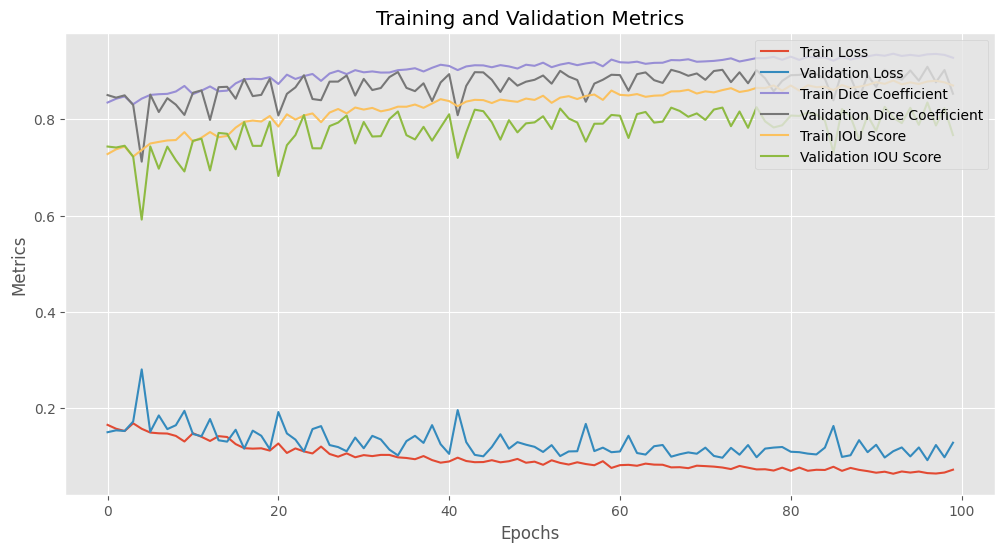

In [41]:
plt.figure(figsize=(12, 6))

# Tracer la perte (loss)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Tracer Dice Coefficient
if 'dice_coefficient' in history.history:
    plt.plot(history.history['dice_coefficient'], label='Train Dice Coefficient')
if 'val_dice_coefficient' in history.history:
    plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')

# Tracer IOU Score
if 'iou_score' in history.history:
    plt.plot(history.history['iou_score'], label='Train IOU Score')
if 'val_iou_score' in history.history:
    plt.plot(history.history['val_iou_score'], label='Validation IOU Score')

# Tracer Recall
if 'recall' in history.history:
    plt.plot(history.history['recall'], label='Train Recall')
if 'val_recall' in history.history:
    plt.plot(history.history['val_recall'], label='Validation Recall')

# Tracer Precision
if 'precision' in history.history:
    plt.plot(history.history['precision'], label='Train Precision')
if 'val_precision' in history.history:
    plt.plot(history.history['val_precision'], label='Validation Precision')

plt.title("Training and Validation Metrics")
plt.ylabel("Metrics")
plt.xlabel("Epochs")
plt.legend(loc="upper right")
plt.grid(True)

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


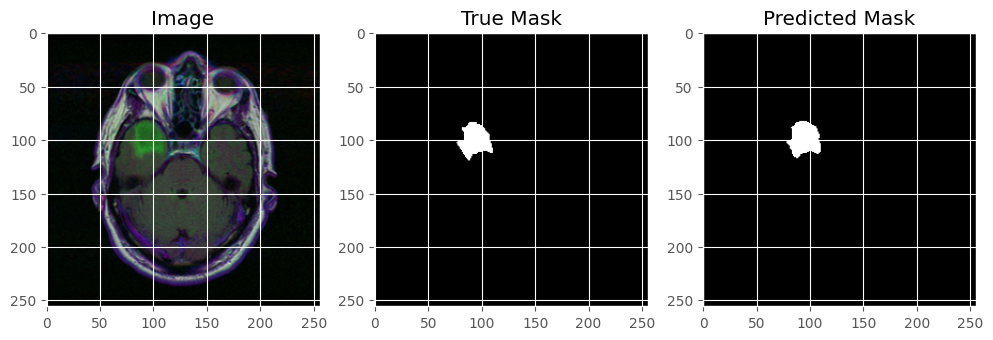

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


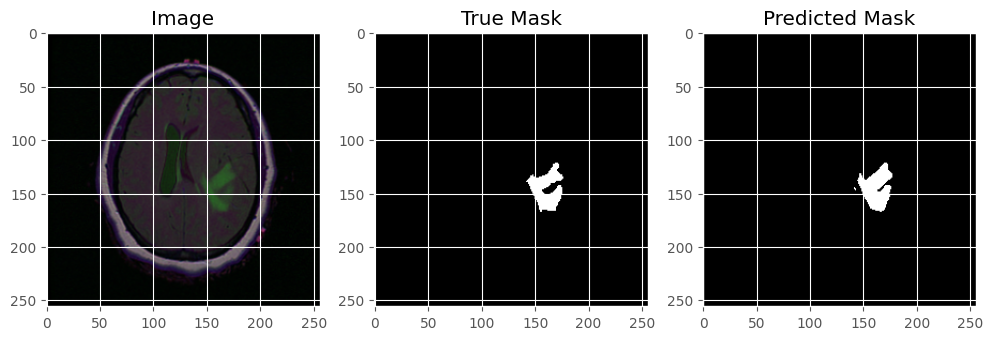

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


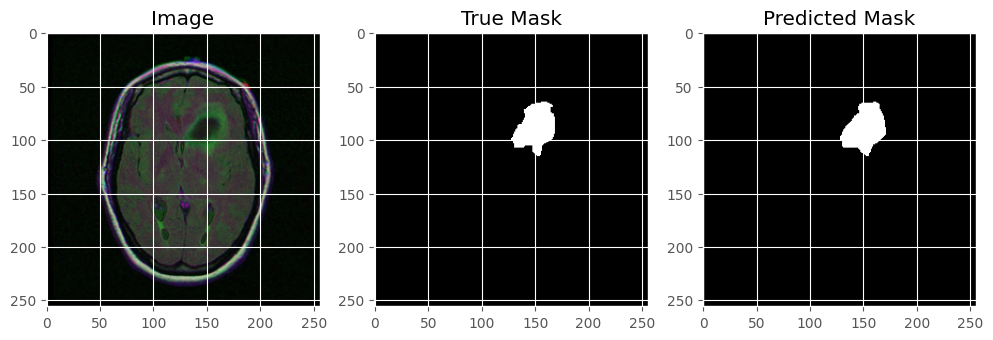

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


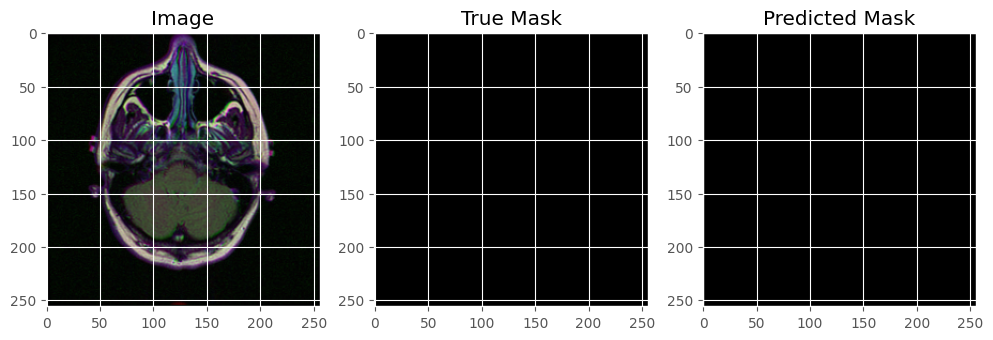

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


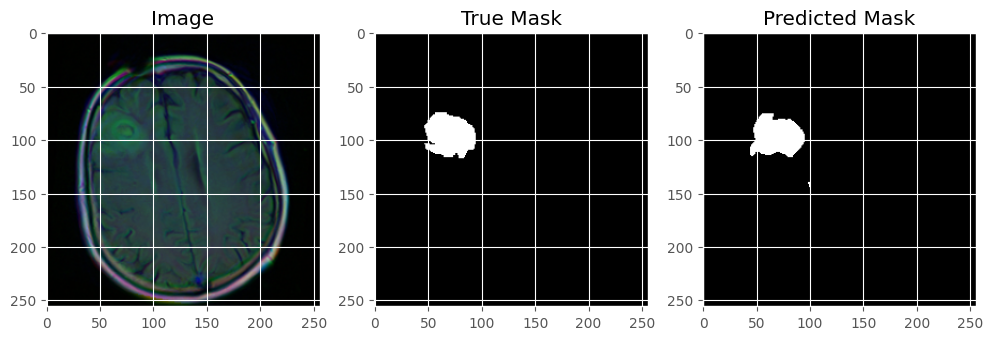

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


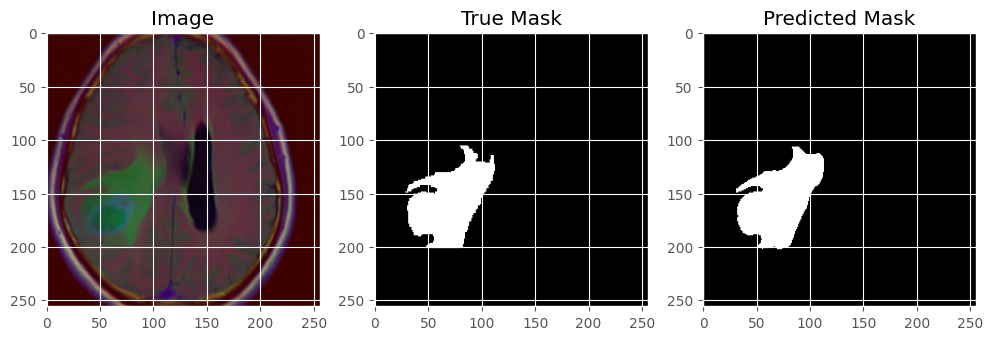

In [37]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(6):
    image, mask = next(test_generator)
    predicted_mask = model.predict(image)
    binary_predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image[0])

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(mask[0].squeeze(), cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(binary_predicted_mask[0].squeeze(), cmap="gray")

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


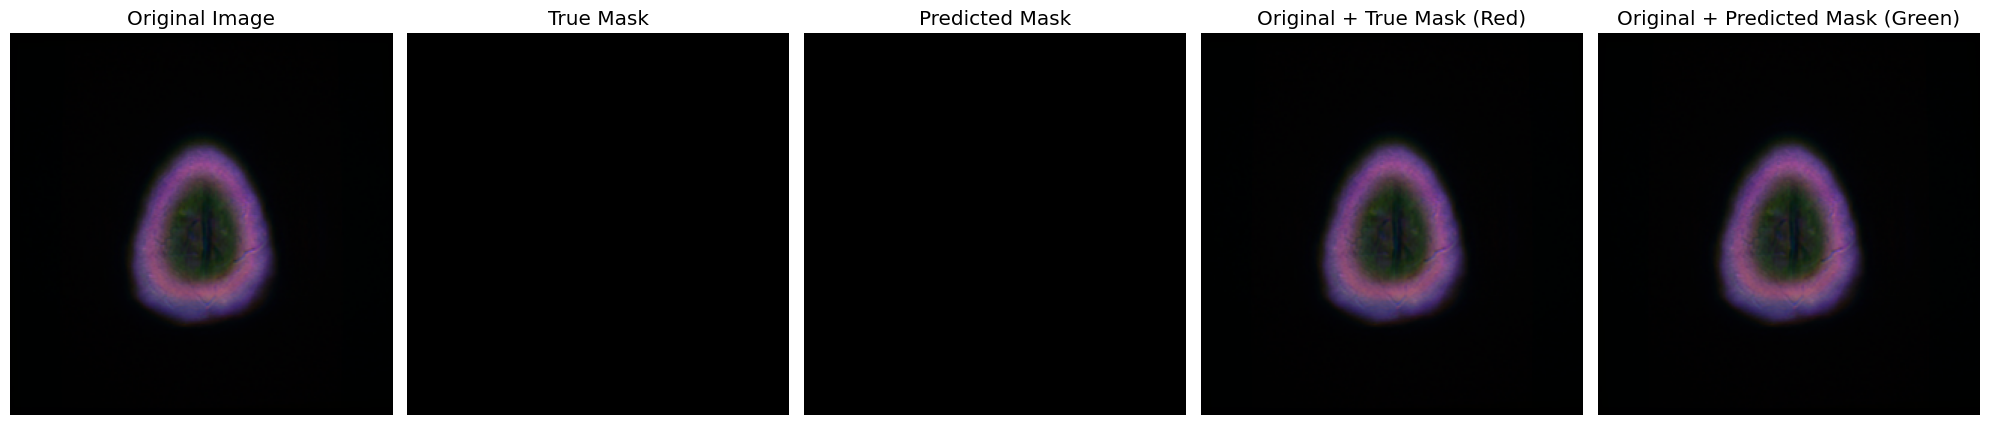

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


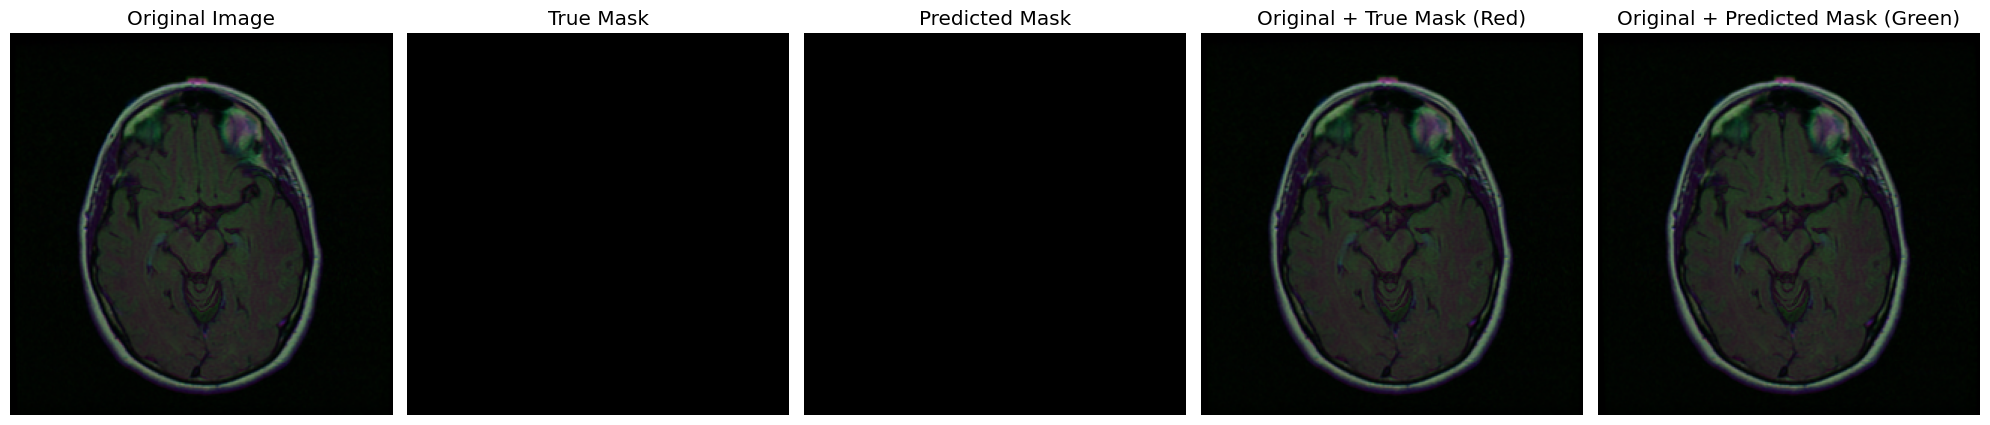

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


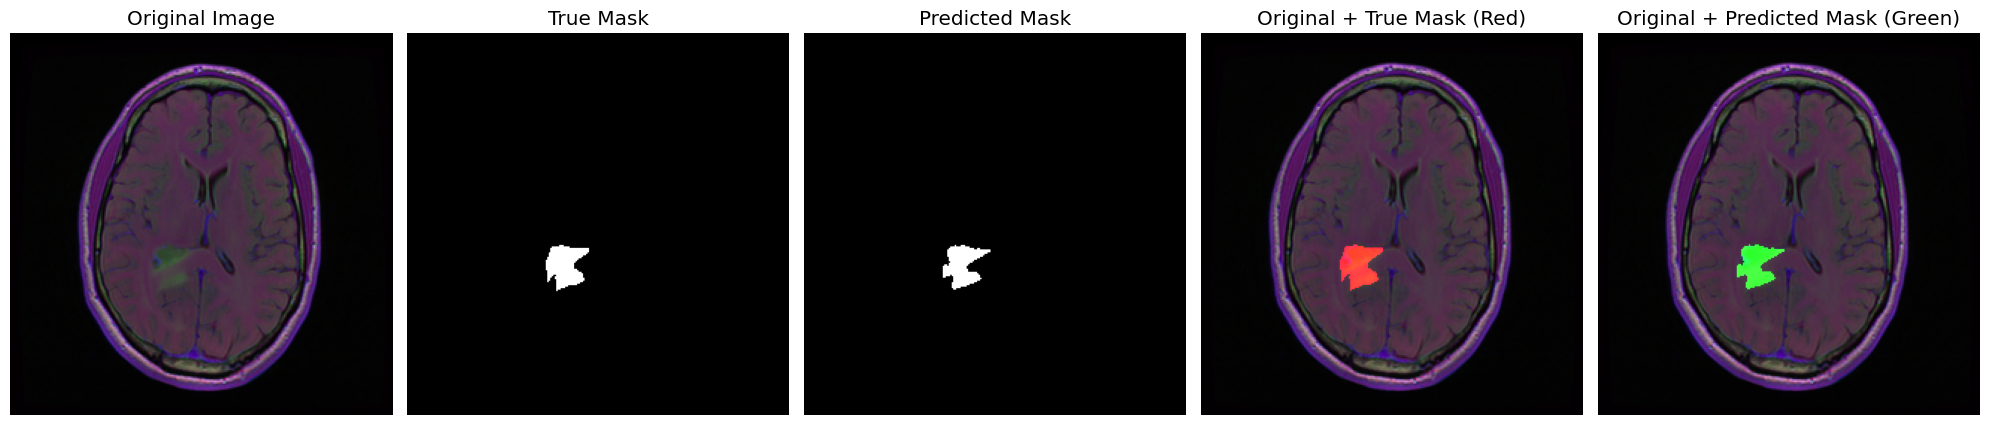

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


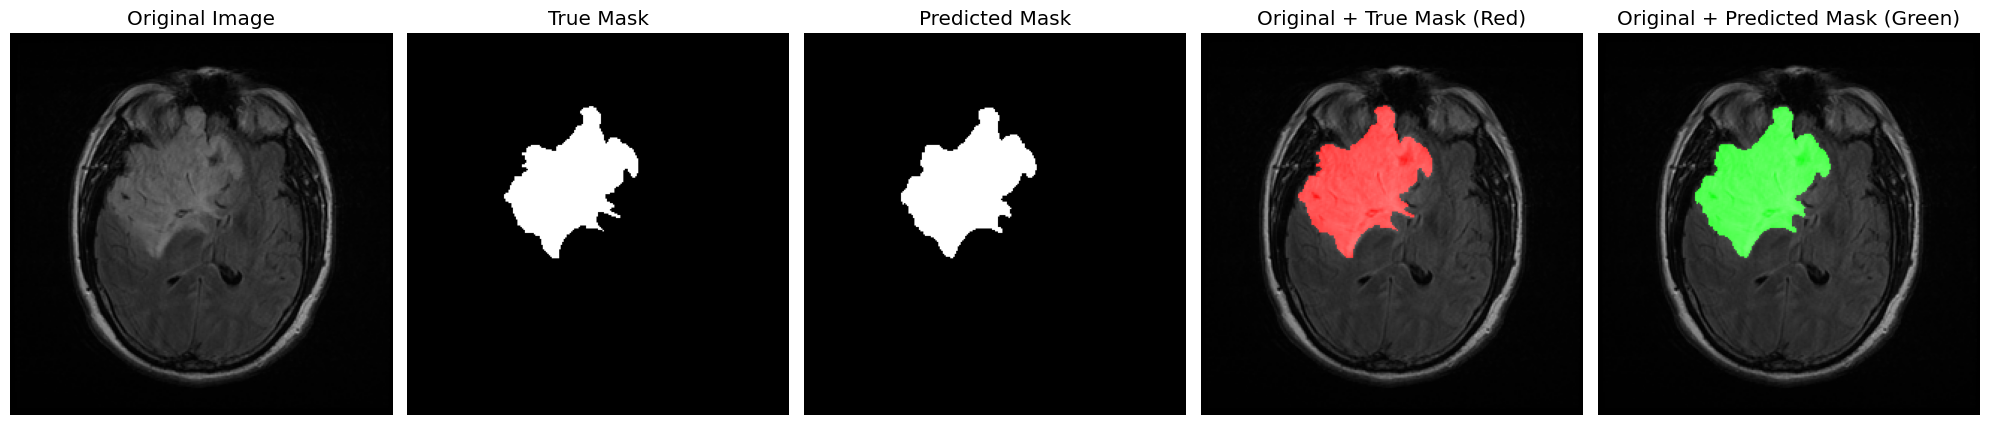

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


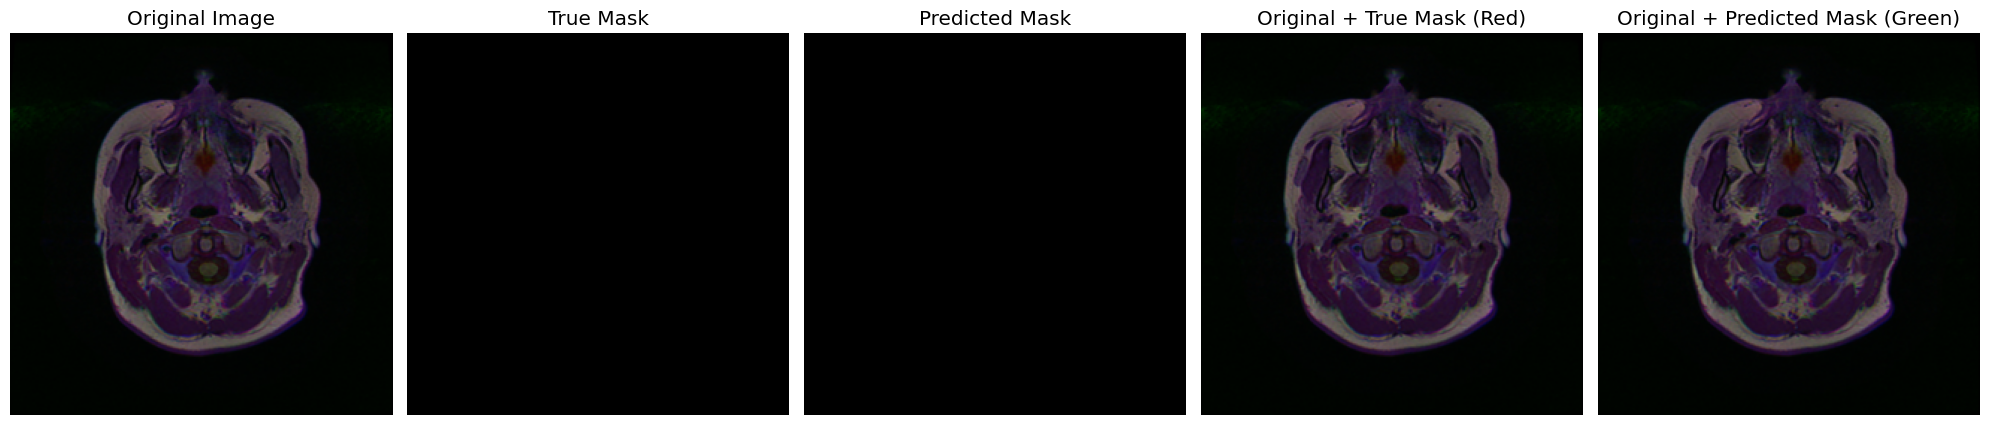

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


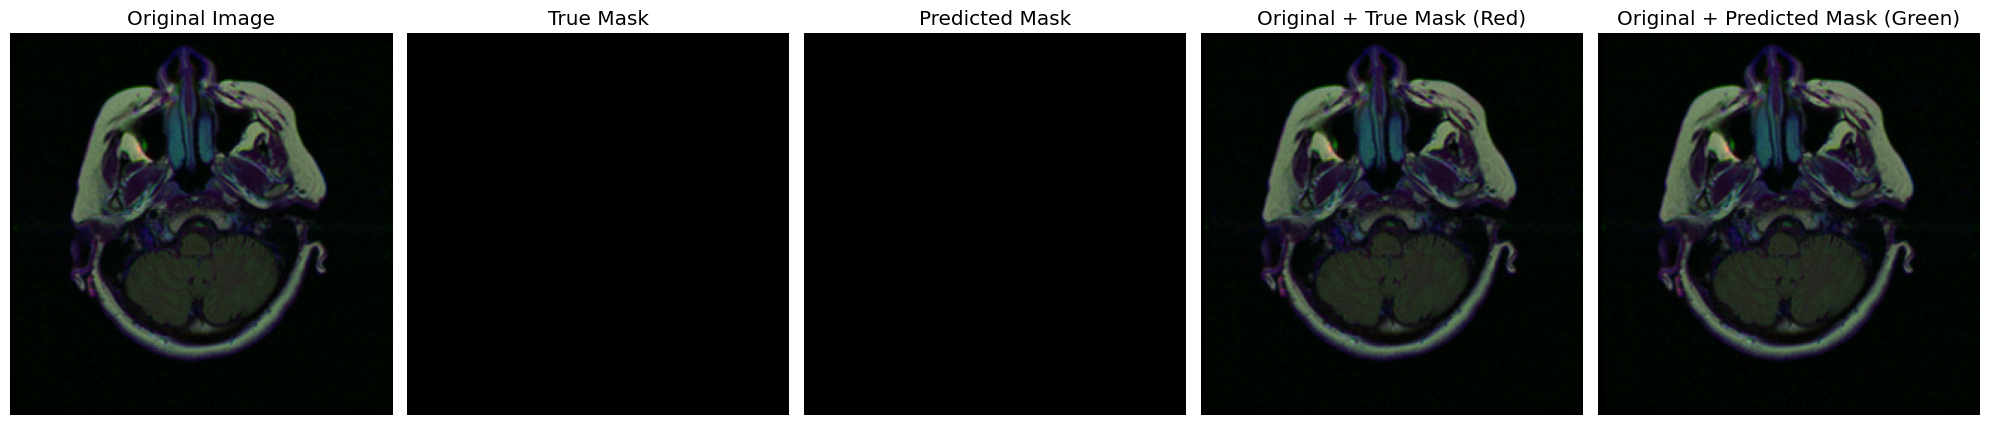

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


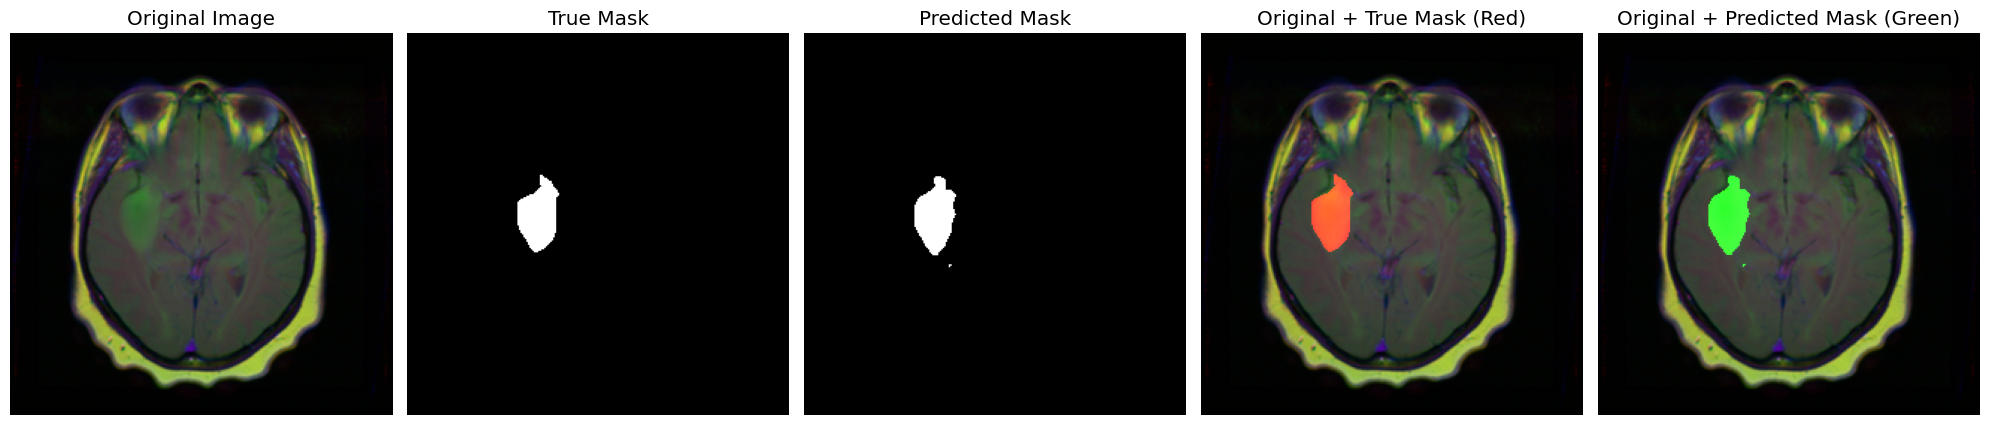

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


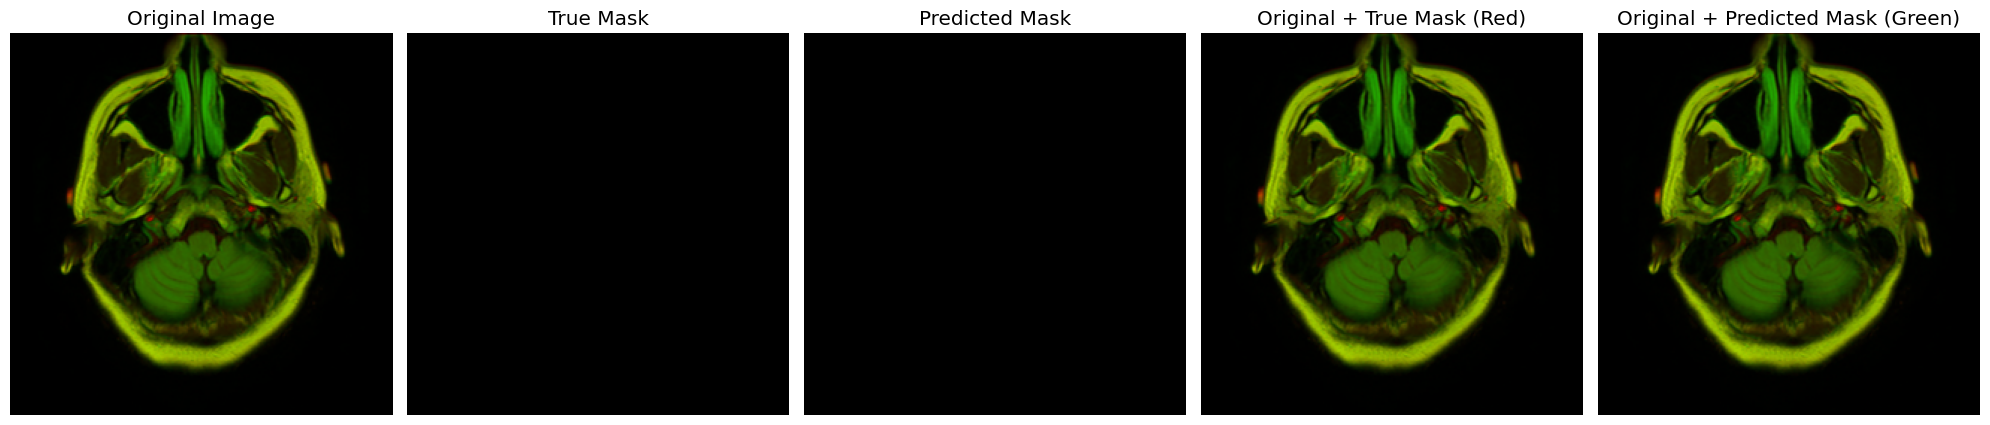

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


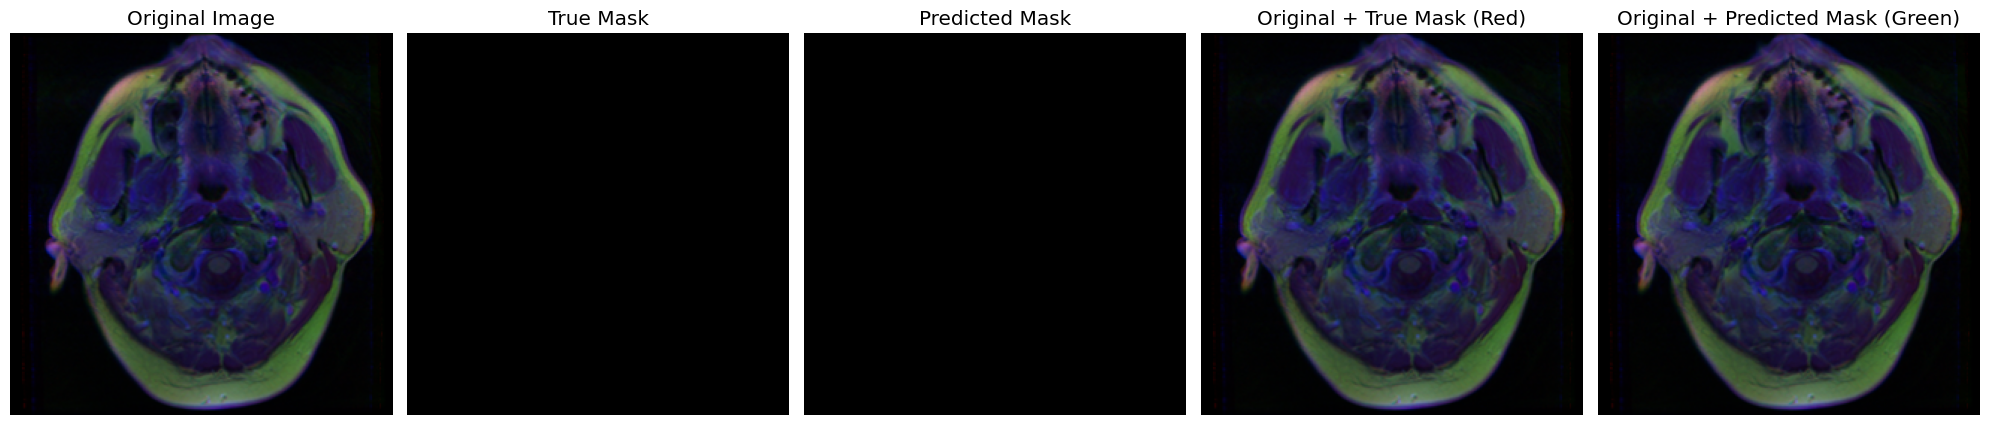

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


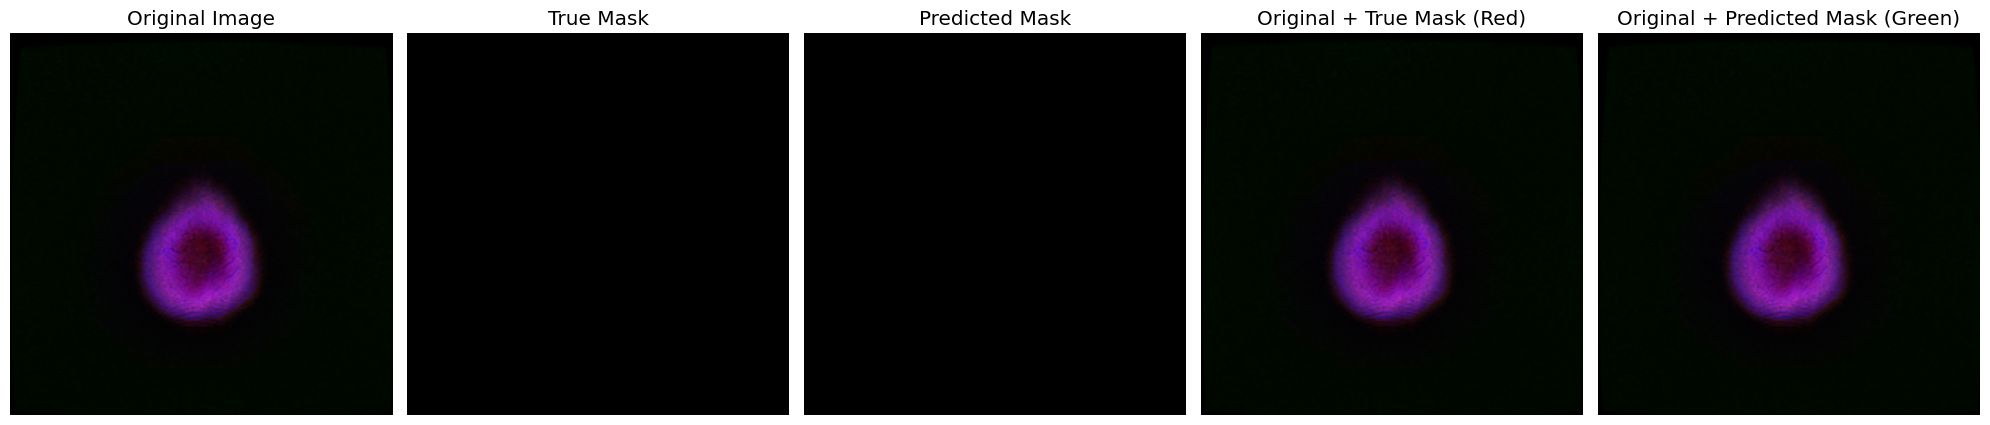

In [ ]:
for i in range(10):
    image, mask = next(test_generator)
    predicted_mask = model.predict(image)
    binary_predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    # Création des images avec superpositions
    image_with_true_mask = image[0].copy()  
    image_with_predicted_mask = image[0].copy() 

    image_with_true_mask[..., 0] = np.maximum(image_with_true_mask[..., 0], mask[0].squeeze() * 255) 

    image_with_predicted_mask[..., 1] = np.maximum(image_with_predicted_mask[..., 1], binary_predicted_mask[0].squeeze() * 255)  

    plt.figure(figsize=(20, 8))

    # Image originale
    plt.subplot(1, 5, 1)
    plt.title("Original Image")
    plt.imshow(image[0])
    plt.axis("off")

    # Masque réel
    plt.subplot(1, 5, 2)
    plt.title("True Mask")
    plt.imshow(mask[0].squeeze(), cmap="gray")
    plt.axis("off")

    # Masque prédit
    plt.subplot(1, 5, 3)
    plt.title("Predicted Mask")
    plt.imshow(binary_predicted_mask[0].squeeze(), cmap="gray")
    plt.axis("off")

    # Image + True Mask
    plt.subplot(1, 5, 4)
    plt.title("Original + True Mask (Red)")
    plt.imshow(image_with_true_mask)
    plt.axis("off")

    # Image + Predicted Mask
    plt.subplot(1, 5, 5)
    plt.title("Original + Predicted Mask (Green)")
    plt.imshow(image_with_predicted_mask)
    plt.axis("off")

    plt.tight_layout()
    plt.show()


---
## <span style="color:green">Conclusion</span>

The **Attention U-Net** model demonstrates strong performance in the task of brain tumor segmentation from MRI images. By incorporating an attention mechanism, the model is able to focus on the relevant parts of the image, which leads to improved segmentation accuracy, particularly in cases where the target regions (such as tumors) are small or irregular. With high **Dice coefficient**, **IoU**, and **precision/recall** scores, this model can be effectively used for medical image segmentation tasks and can be extended to other domains in medical imaging.

